In [1]:
import torch
import pandas as pd
import numpy as np
import joblib
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC
import torch.optim as optim
from sklearn.model_selection import GridSearchCV


def get_result(y_test,pred):
    print('Acc',accuracy_score(y_test,pred))
    print('f1',f1_score(y_test,pred))
    print('precision',precision_score(y_test,pred))

# Training steps

In [2]:
df = pd.read_csv('bank-full.csv',sep=';')
df_train,df_test = train_test_split(df, test_size=0.20, random_state=42)
# df_test.to_csv('test.csv',index=False)

X_train = df_train.drop('y',axis=1)
y_train = df_train['y']
y_train = y_train.replace(['yes','no'],[1,0])
X_train.drop('poutcome',axis=1,inplace=True)

In [3]:
y_train.value_counts(normalize=True)

0    0.883931
1    0.116069
Name: y, dtype: float64

In [4]:
X_train.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
dtype: int64

In [5]:
X_train

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous
3344,41,blue-collar,married,primary,no,849,yes,no,unknown,15,may,72,1,-1,0
17965,49,technician,married,primary,no,1415,yes,no,cellular,30,jul,269,2,-1,0
18299,42,admin.,married,secondary,no,3842,no,no,cellular,31,jul,130,4,-1,0
10221,37,management,single,tertiary,no,-119,yes,no,unknown,11,jun,375,11,-1,0
32192,56,blue-collar,married,primary,no,3498,no,no,cellular,15,apr,264,2,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,44,housemaid,single,primary,no,1059,no,no,unknown,18,jun,2093,1,-1,0
44732,23,student,single,tertiary,no,508,no,no,cellular,8,sep,210,1,92,1
38158,34,technician,divorced,tertiary,no,1317,yes,no,cellular,15,may,239,1,-1,0
860,33,retired,married,secondary,no,165,no,no,unknown,7,may,111,1,-1,0


In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
# Columns to apply StandardScaler and OneHotEncoder
categorical_cols = list(set(X_train.select_dtypes('O')))
numeric_cols = list(set(X_train) - set(X_train.select_dtypes('O')))

# Define preprocessing steps for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler())  # Standard scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to the entire dataset
X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

In [8]:
# save preprocessor
joblib.dump(preprocessor, "preprocessor.pkl") 

['preprocessor.pkl']

In [9]:
up_sample = SMOTE(random_state=42)
down_sample = RandomUnderSampler(random_state=42)

X_train_up, y_train_up = up_sample.fit_resample(X_train,y_train)
X_train_down, y_train_down = down_sample.fit_resample(X_train,y_train)

# SVM Training and model save
- on actual, upsampled and downsampled

In [10]:
def exp_svc(k):
    for title, (train_x,train_y) in zip(['imbalanced','upsampled','downsampled'],[(X_train,y_train),(X_train_up,y_train_up), (X_train_down,y_train_down)]):
        svc_clf = SVC(kernel=k,random_state = 0)
        svc_clf.fit(train_x,train_y)
        
        # save
        joblib.dump(svc_clf, f"SVM_{title}_{k}.pkl") 
        pred_svc = svc_clf.predict(X_test)
        cm = confusion_matrix(y_test, pred_svc, labels=svc_clf.classes_)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
        disp.plot(values_format=".2f")
        plt.title(title)
        plt.show()
        get_result(y_test,pred_svc)

In [11]:
# test
df_test = pd.read_csv('test.csv',sep=',')
df_test.drop('poutcome',axis=1,inplace=True)
X_test = df_test.drop('y',axis=1)
y_test = df_test['y']
y_test = y_test.replace(['yes','no'],[1,0])

X_test = preprocessor.transform(X_test)

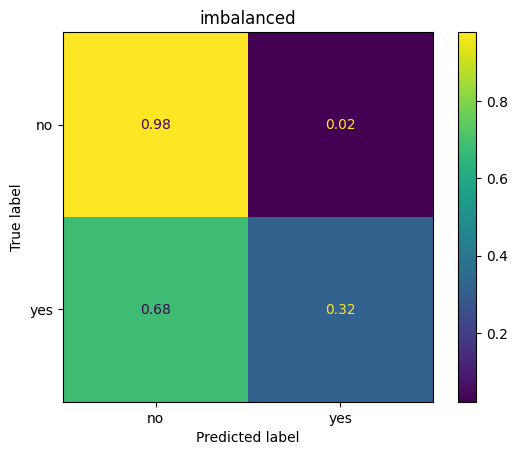

Acc 0.8983744332632976
f1 0.4309597523219814
precision 0.6641221374045801


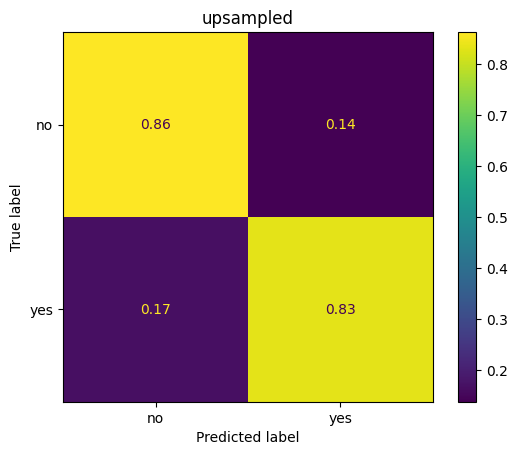

Acc 0.8587858011721774
f1 0.5873990306946688
precision 0.4535928143712575


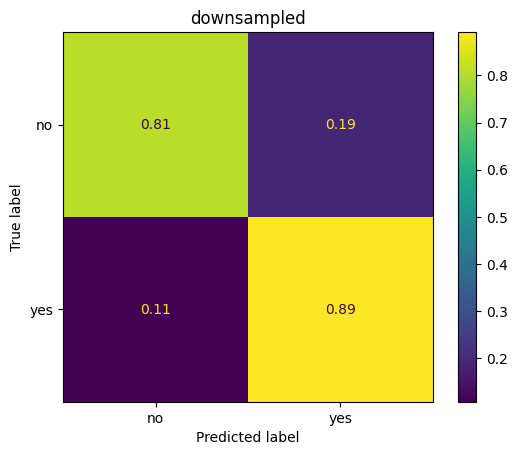

Acc 0.8191971690810572
f1 0.5434236246858419
precision 0.39076305220883534


In [12]:
exp_svc('rbf')

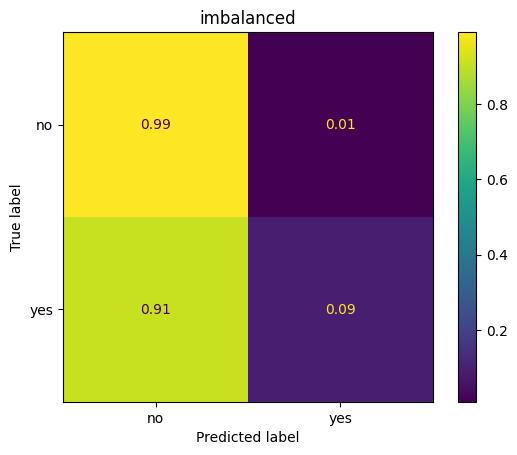

Acc 0.8823399314386818
f1 0.15822784810126583
precision 0.5780346820809249


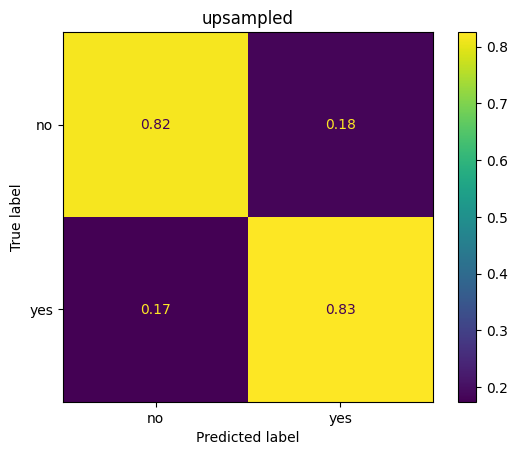

Acc 0.8169855136569723
f1 0.5212612091408736
precision 0.3808114961961116


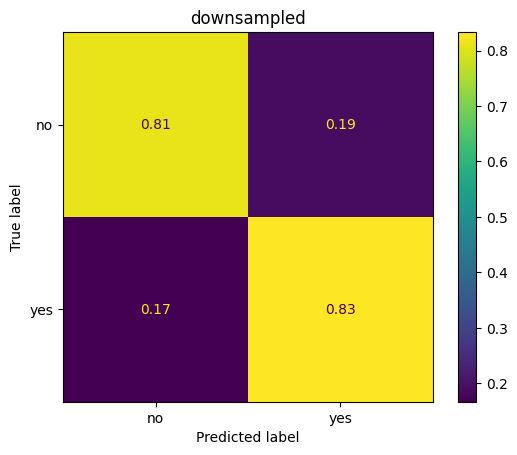

Acc 0.8144421099192746
f1 0.5200228832951945
precision 0.377962577962578


In [13]:
exp_svc('linear')

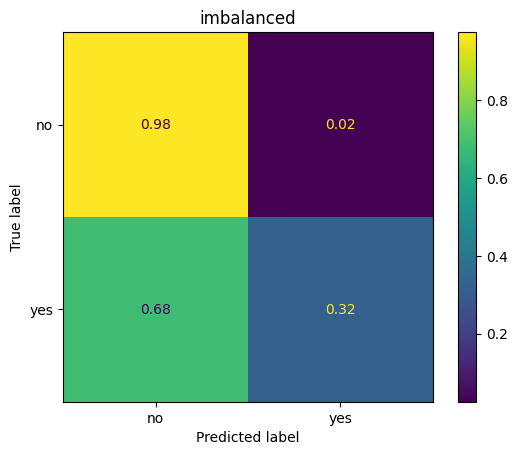

Acc 0.8958310295255999
f1 0.4227941176470588
precision 0.6377079482439926


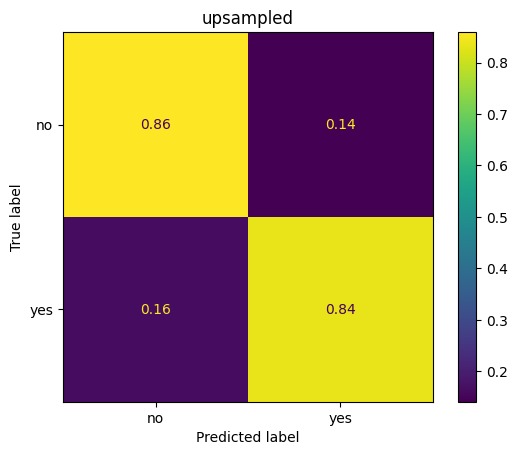

Acc 0.8562423974344797
f1 0.5838668373879642
precision 0.4485981308411215


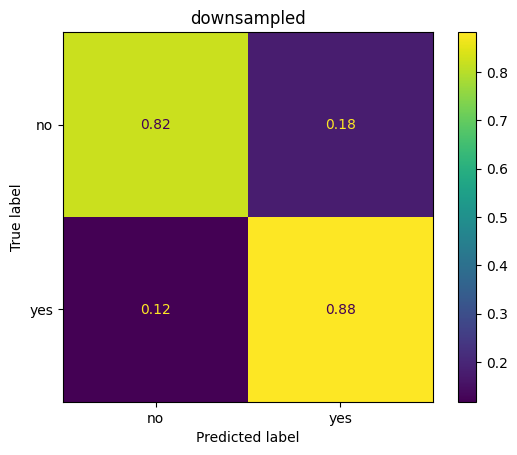

Acc 0.8279332080061926
f1 0.553130384836301
precision 0.4027603513174404


In [14]:
exp_svc('poly')

# MLP

In [15]:
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train.values)
X_train_t = X_train_t.to(dtype=torch.float32)
y_train_t = y_train_t.to(torch.int64)


X_train_up = torch.tensor(X_train_up)
y_train_up = torch.tensor(y_train_up.values)
X_train_up = X_train_up.to(dtype=torch.float32)
y_train_up = y_train_up.to(torch.int64)


X_train_down = torch.tensor(X_train_down)
y_train_down = torch.tensor(y_train_down.values)
X_train_down = X_train_down.to(dtype=torch.float32)
y_train_down = y_train_down.to(torch.int64)

X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test.values)
X_test_t = X_test_t.to(dtype=torch.float32)
y_test_t = y_test_t.to(torch.int64)

In [16]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an instance of your custom neural network
mymodel = StockClassifier(47,2)

# Actual data

In [17]:
# Create an instance of the neural network classifier
net = NeuralNetClassifier(
    module=mymodel,
    optimizer__momentum=0.95,
    module__input_dim=X_train.shape[1],  # Input dimension
    module__num_classes=2,  # Number of output classes
    criterion=nn.CrossEntropyLoss,  # Loss function
    optimizer=optim.SGD,  # Optimizer
    optimizer__lr=0.01,  # Learning rate
    optimizer__weight_decay=1e-5,  # L2 regularization
    max_epochs=50,  # Maximum number of training epochs
    batch_size=128,  # Batch size for training
    iterator_train__shuffle=True,  # Shuffle training data
    callbacks=[EarlyStopping(patience=3)]  # Early stopping callback
)

# Define hyperparameters to tune
params = {
    'optimizer__momentum': [0.5, 0.9,.999],
    'optimizer__weight_decay': [1e-4, 1e-5],
}

# Perform grid search with cross-validation
gs = GridSearchCV(net, params, cv=3, scoring='accuracy', verbose=1,n_jobs=-1)
gs.fit(X_train_t, y_train_t)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3477       0.8847        0.2615  0.9521
      2        0.2609       0.8864        0.2422  1.0031
      3        0.2507       0.8880        0.2355  1.0288
      4        0.2460       0.8882        0.2319  0.9517
      5        0.2416       0.8890        0.2302  0.9905
      6        0.2390       0.8902        0.2279  1.0533
      7        0.2343       0.8912        0.2250  1.0330
      8        0.2318       0.8913        0.2266  1.0227
      9        0.2306       0.8941        0.2227  0.9830
     10        0.2310       0.8937        0.2216  1.0564
     11        0.2281       0.8942        0.2208  1.0848
     12        0.2271       0.8937        0.2193  0.9871
     13        0.2255       0.8958        0.2187  0.9650
     14        0.2244       0.8941        0.2171  1.0843
     15        0.2229       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 1e-05}
Acc 0.9023554130266505
f1 0.5436692506459948
precision 0.6232227488151659


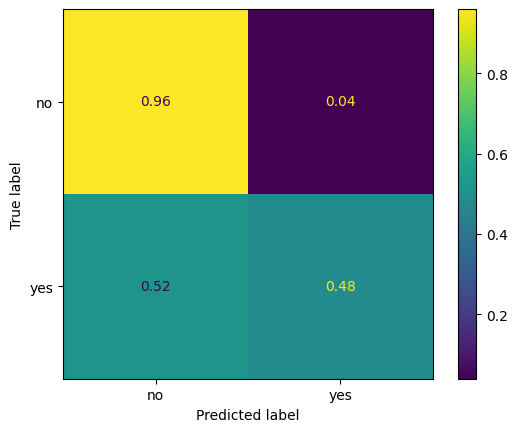

In [18]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='best_model_params.pkl',
                               f_optimizer='best_optimizer_params.pkl',
                               f_history='best_history.json',
                               f_pickle='best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)

cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# Up sampled

In [19]:
gs.fit(X_train_up, y_train_up)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4883       0.8381        0.3802  1.8981
      2        0.3698       0.8504        0.3569  1.7753
      3        0.3475       0.8596        0.3457  1.7512
      4        0.3379       0.8646        0.3364  1.7466
      5        0.3284       0.8657        0.3324  1.7820
      6        0.3229       0.8690        0.3266  1.8093
      7        0.3185       0.8693        0.3243  1.7955
      8        0.3131       0.8737        0.3183  1.8528
      9        0.3115       0.8727        0.3153  1.8342
     10        0.3054       0.8735        0.3111  1.7488
     11        0.3043       0.8744        0.3111  1.7635
     12        0.3038       0.8749        0.3110  1.9597
     13        0.2986       0.8741        0.3157  1.8407
     14        0.2981       0.8773        0.3063  1.6967
     15        0.2958       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 1e-05}
Acc 0.8561318146632755
f1 0.5878999049730758
precision 0.4491771539206196


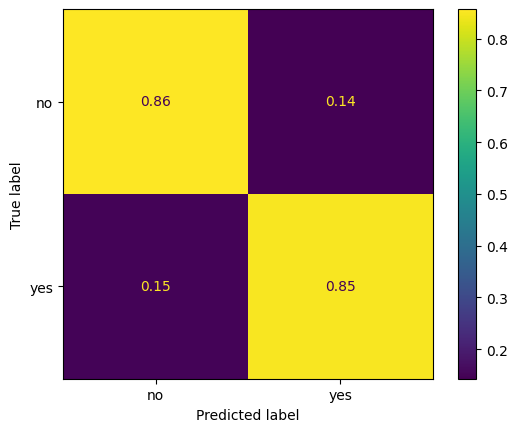

In [20]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='up_best_model_params.pkl',
                               f_optimizer='up_best_optimizer_params.pkl',
                               f_history='up_best_history.json',
                               f_pickle='up_best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)
cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# down sampled

In [21]:
# Train the model
gs.fit(X_train_down, y_train_down)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6538       0.7774        0.5803  0.2001
      2        0.5206       0.8119        0.4347  0.2394
      3        0.4579       0.8143        0.4146  0.2299
      4        0.4463       0.8238        0.4063  0.2214
      5        0.4273       0.8286        0.3981  0.2314
      6        0.4200       0.8280        0.3940  0.2573
      7        0.4167       0.8304        0.3915  0.2773
      8        0.4070       0.8333        0.3894  0.2449
      9        0.4068       0.8310        0.3875  0.2399
     10        0.4027       0.8333        0.3832  0.2219
     11        0.3957       0.8351        0.3808  0.2480
     12        0.3954       0.8339        0.3795  0.2334
     13        0.3917       0.8363        0.3768  0.2349
     14        0.3916       0.8327        0.3759  0.2544
     15        0.3869       

GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=StockClassifier(
    (fc1): Linear(in_features=47, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  ),
  module__input_dim=47,
  module__num_classes=2,
),
             n_jobs=-1,
             param_grid={'optimizer__momentum': [0.5, 0.9, 0.999],
                         'optimizer__weight_decay': [0.0001, 1e-05]},
             scoring='accuracy', verbose=1)

Best parameters: {'optimizer__momentum': 0.9, 'optimizer__weight_decay': 1e-05}
Acc 0.806590733163773
f1 0.5299650631550659
precision 0.3749049429657795


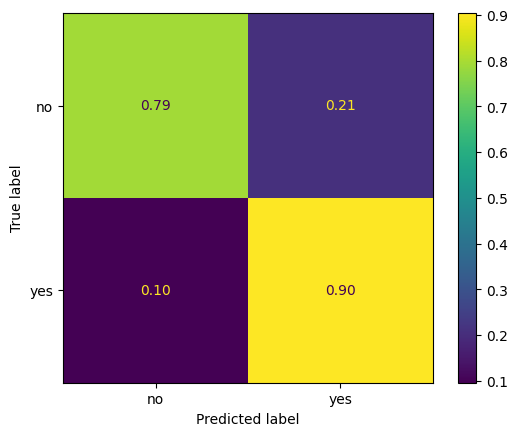

In [22]:
# Evaluate the model
gs.best_estimator_.save_params(f_params='down_best_model_params.pkl',
                               f_optimizer='down_best_optimizer_params.pkl',
                               f_history='down_best_history.json',
                               f_pickle='down_best_model.pkl')

print("Best parameters:", gs.best_params_)
best_model = gs.best_estimator_
pred = best_model.predict(X_test_t)
get_result(y_test_t,pred)

cm = confusion_matrix(y_test, pred, labels=best_model.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.show()

# TESTING

# SVM Testing on best saved model

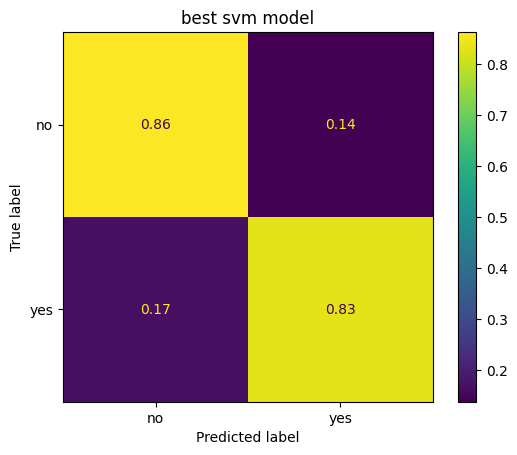

Acc 0.8587858011721774
f1 0.5873990306946688
precision 0.4535928143712575


In [23]:
best_svm_model = 'SVM_upsampled_rbf.pkl'

test = pd.read_csv('test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

# load model
clf = joblib.load(f"{best_svm_model}")

pred_svc = clf.predict(Xtest)
cm = confusion_matrix(ytest, pred_svc, labels=clf.classes_)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best svm model')
plt.show()
get_result(ytest,pred_svc)

# MLP Testing on best saved model

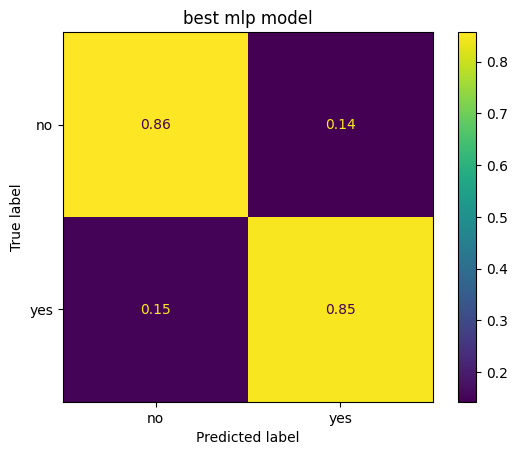

Acc 0.8561318146632755
f1 0.5878999049730758
precision 0.4491771539206196


In [24]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

Mymodel = StockClassifier(47,2)

best_mlp_model = NeuralNetClassifier(module=Mymodel)
best_mlp_model.initialize()
best_mlp_model.load_params(f_params='up_best_model_params.pkl',
                    f_optimizer='up_best_optimizer_params.pkl', 
                    f_history='up_best_history.json', 
                    f_pickle='up_best_model.pkl')


test = pd.read_csv('test.csv',sep=',')
test.drop('poutcome',axis=1,inplace=True)
Xtest = test.drop('y',axis=1)
ytest = test['y']
ytest = ytest.replace(['yes','no'],[1,0])
# load preprocessor
loaded_preprocessor = joblib.load("preprocessor.pkl")
Xtest = loaded_preprocessor.transform(Xtest)

X_test_tensor = torch.tensor(Xtest)
y_test_tensor = torch.tensor(ytest.values)
X_test_tensor = X_test_tensor.to(dtype=torch.float32)
y_test_tensor = y_test_tensor.to(torch.int64)

pred_mlp = best_mlp_model.predict(X_test_tensor)
cm = confusion_matrix(ytest, pred_mlp, labels=[0,1])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
disp.plot(values_format=".2f")
plt.title('best mlp model')
plt.show()
get_result(y_test_tensor,pred_mlp)